In [2]:
## Standard Imports ##
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

import numpy as np
import scipy as sp

import time as timeit
import datetime
import sys,os

## Examining the Results
This file was built to standardize the examination of the results from each inference method, while still giving the opportunity to look closely at the performance of each algorithm. The results of the 50 inference trials for each case are first examinged collectively, and the best inference trial is singled out for closer examination. The option is also given to plot the detailed results for any specified inference case. 

__Developed by__: Alana Lund (Purdue University) \
__Last Updated__: 13 Sept. 2021 \
__License__: AGPL-3.0

## Load Experimental Data

In [3]:
## Assert File Names
inFile = '../04-Data/Linear/inferenceInput'
infData = np.load(inFile + '.npz')

dt = infData['dt']                 # time step [sec]
time = infData['time']             # time history [sec]
inpAcc = infData['inpAcc']         # observations on input acceleration [m/sec^2]
states = infData['statesPNoise']   # states (for post-inference validation) [m,m/sec]
respAcc = infData['accPMNoise']    # observations on response acceleration [m/sec^2]
Q = infData['Qfactor']             # process noise contributions, independent std. dev. per state [m,m/sec]
R = infData['Rfactor']             # nondimesnional measurement noise contribution [m/sec^2]
m = infData['m']                   # mass [kg]
ics = infData['ics']               # true initial conditions of the system [m, m/sec]
par = infData['par']               # true parameters of the system [xi (-), wn (rad/sec)] 

## Inference Results
### Load Inference Data

In [4]:
outFile = '../04-Data/Linear/outputEKF'
outData = np.load(outFile + '.npz')

muHist = outData['muHist']         # inference history of untransformed state/par means
stdHist = outData['stdHist']       # inference history of state/par standard deviations
meanHist = outData['meanHist']     # inference history of transformed state/par means
modeHist = outData['modeHist']     # inference history of transformed state/par modes
modStates = outData['modStates']  # states that have been remodeled based on the final modes of the parameters

### Plot Comprehensive Results
This set of figures is intended to give an overview of the results for all inference trials. 

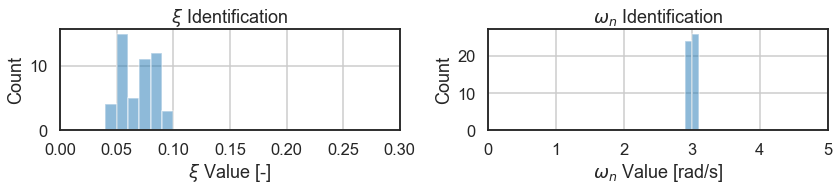

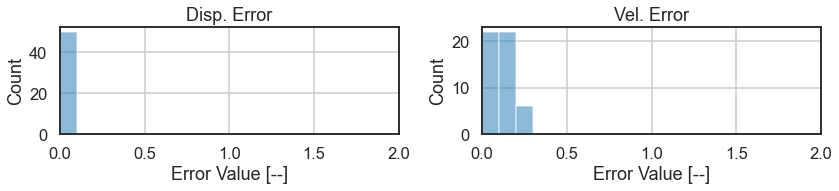

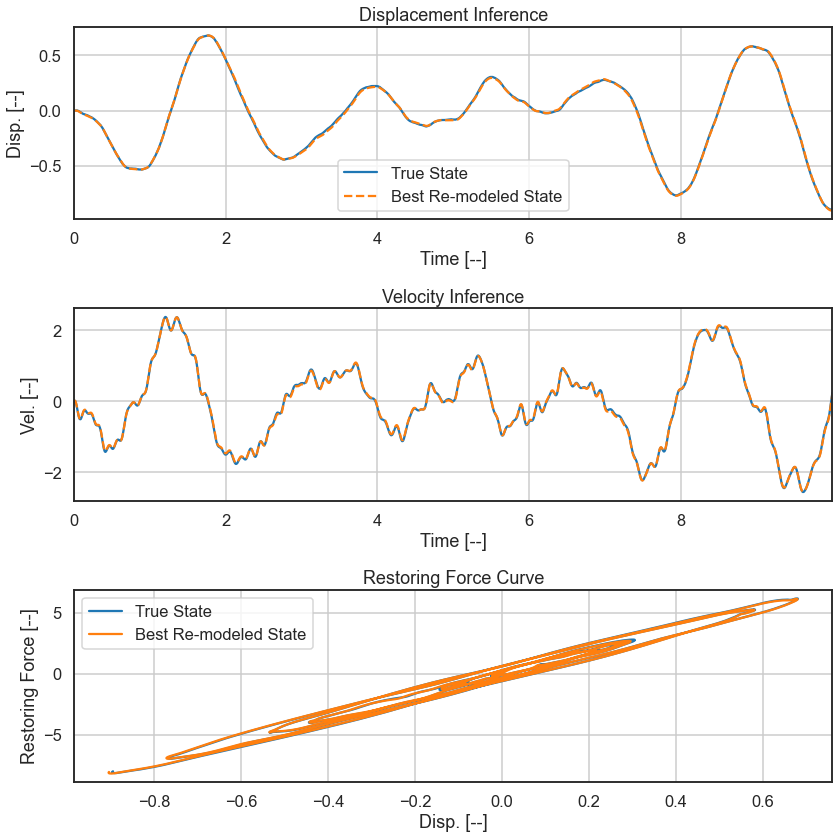

In [5]:
## Linear Parameters ##
fig, ax = plt.subplots(1,2,figsize = (12,3))
ax[0].hist(modeHist[:,2,-1], bins = np.concatenate((np.arange(0,0.3, 0.01), np.array([1]))), label = r"\xi", alpha = 0.5)
ax[0].set_title(r'$\xi$ Identification')
ax[0].set_ylabel('Count')
ax[0].set_xlabel(r'$\xi$ Value [-]')
ax[0].set_xlim((0,0.3))
ax[0].grid(1)
#ax[0].legend()

ax[1].hist(modeHist[:,3,-1], bins = np.concatenate((np.arange(0,5, 0.1), np.array([100]))), label = r'$\omega_n$', alpha = 0.5)
ax[1].set_title(r'$\omega_n$ Identification')
ax[1].set_ylabel('Count')
ax[1].set_xlabel(r'$\omega_n$ Value [rad/s]')
ax[1].set_xlim((0,5))
ax[1].grid(1)

plt.tight_layout()

## State Error ##
RMSDisp = np.sqrt(np.mean(np.square(states[0] - modStates[:,0,:]), axis=1))
findNans = np.isnan(RMSDisp)
RMSDisp[findNans] = 5
RMSVel = np.sqrt(np.mean(np.square(states[1] - modStates[:,1,:]), axis=1))
findNans = np.isnan(RMSVel)
RMSVel[findNans] = 5

fig, ax = plt.subplots(1,2,figsize = (12,3))
ax[0].hist(RMSDisp, bins = np.concatenate((np.arange(0,2, 0.1), np.array([20]))), label = r'Disp.', alpha = 0.5)
ax[0].set_title(r'Disp. Error')
ax[0].set_ylabel('Count')
ax[0].set_xlabel(r'Error Value [--]')
ax[0].set_xlim((0,2))
ax[0].grid(1)
#ax[0].legend()

ax[1].hist(RMSVel, bins = np.concatenate((np.arange(0,2, 0.1), np.array([20]))), label = "Vel.", alpha = 0.5)
ax[1].set_title('Vel. Error')
ax[1].set_ylabel('Count')
ax[1].set_xlabel('Error Value [--]')
ax[1].set_xlim((0,2))
ax[1].grid(1)

plt.tight_layout()  

## State Error ##
index = np.argmin(RMSDisp)

figure, ax=plt.subplots(3,1,figsize=(12,12)) 
ax[0].plot(time, states[0], '-', label='True State')
ax[0].plot(time, modStates[index, 0,:], '--', label='Best Re-modeled State')
ax[0].set_xlabel('Time [--]')
ax[0].set_ylabel('Disp. [--]')
ax[0].set_title('Displacement Inference')
ax[0].set_xlim((0, time[-1]))
ax[0].grid(1)
ax[0].legend()

ax[1].plot(time, states[1], '-', label='True State')
ax[1].plot(time, modStates[index, 1,:], '--', label='Best Re-modeled State')
ax[1].set_xlabel('Time [--]')
ax[1].set_ylabel('Vel. [--]')
ax[1].set_title('Velocity Inference')
ax[1].set_xlim((0, time[-1]))
ax[1].grid(1)

ax[2].plot(states[0,:],-m*(-2*0.05*3*states[1] - 3**2*states[0]), label="True State")
ax[2].plot(modStates[index,0,:],-m*(-2*modeHist[index,2,-1]*modeHist[index,3,-1]*modStates[index,1,:]
                                    -np.square(modeHist[index,3,-1])*modStates[index,0,:]), label="Best Re-modeled State")
ax[2].set_xlabel('Disp. [--]')
ax[2].set_ylabel('Restoring Force [--]')
ax[2].set_title('Restoring Force Curve')
ax[2].grid(1)
ax[2].legend()

plt.tight_layout()  

### Plot Results for One Case
This set of figures singles out a specific inference case and examines the results in more detail. 

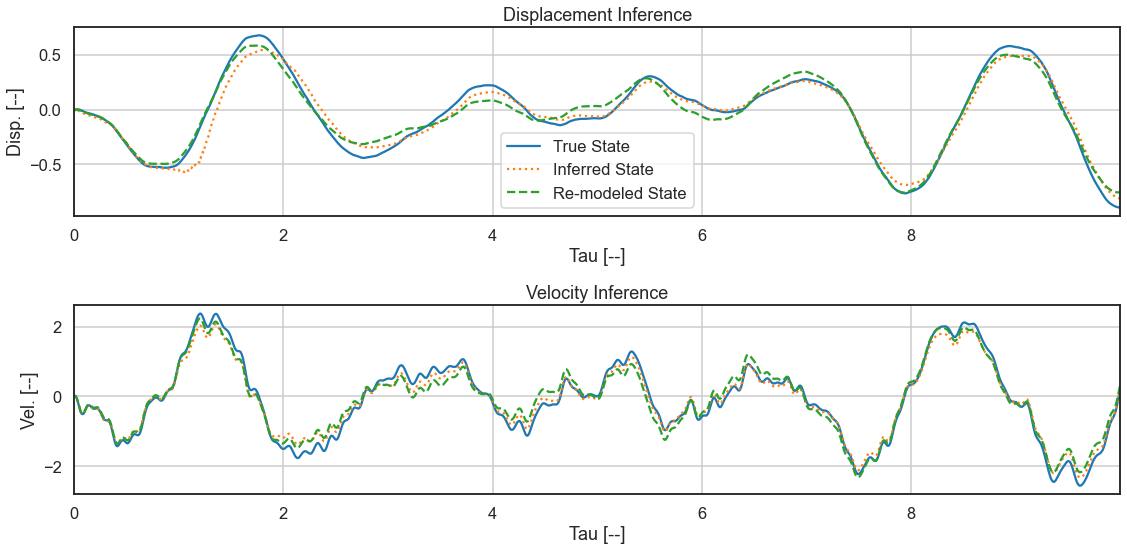

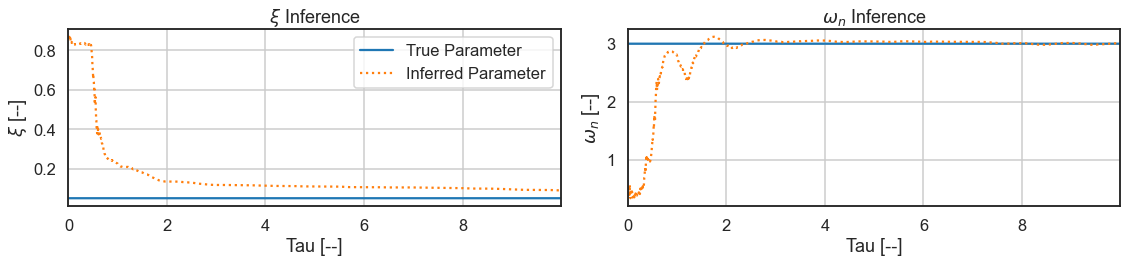

In [6]:
### Plot Results ###
caseSelect = 0

## States ##
figure, ax=plt.subplots(2,1,figsize=(16,8)) 
ax[0].plot(time, states[0], '-', label='True State')
ax[0].plot(time, muHist[caseSelect, 0], ':', label='Inferred State')
ax[0].plot(time, modStates[caseSelect, 0], '--', label='Re-modeled State')
ax[0].set_xlabel('Tau [--]')
ax[0].set_ylabel('Disp. [--]')
ax[0].set_title('Displacement Inference')
ax[0].set_xlim((0, time[-1]))
ax[0].grid(1)
ax[0].legend()

ax[1].plot(time, states[1], '-', label='True State')
ax[1].plot(time, muHist[caseSelect, 1], ':', label='Inferred State')
ax[1].plot(time, modStates[caseSelect, 1], '--', label='Re-modeled State')
ax[1].set_xlabel('Tau [--]')
ax[1].set_ylabel('Vel. [--]')
ax[1].set_title('Velocity Inference')
ax[1].set_xlim((0, time[-1]))
ax[1].grid(1)


plt.tight_layout()

## Parameters ##
figure, ax=plt.subplots(1,2,figsize=(16,4)) 
ax[0].plot(time, 0.05*np.ones(len(time)), '-', label='True Parameter')
ax[0].plot(time, modeHist[caseSelect, 2], ':', label='Inferred Parameter')
ax[0].set_xlabel('Tau [--]')
ax[0].set_ylabel(r'$\xi$ [--]')
ax[0].set_title(r'$\xi$ Inference')
ax[0].set_xlim((0, time[-1]))
ax[0].grid(1)
ax[0].legend()     

ax[1].plot(time, 3*np.ones(len(time)), '-', label='True Parameter')
ax[1].plot(time, modeHist[caseSelect, 3], ':', label='Inferred Parameter')
ax[1].set_xlabel('Tau [--]')
ax[1].set_ylabel(r'$\omega_n$ [--]')
ax[1].set_title(r'$\omega_n$ Inference')
ax[1].set_xlim((0, time[-1]))
ax[1].grid(1)

plt.tight_layout()

## Predictive Results
### Load Predictive Data

In [7]:
predInFile = '../04-Data/Linear/predInp_BLWN'
predOutFile = '../04-Data/Linear/predOutEKF'

### Secondary Excitation Information ###
infData = np.load(predInFile + '.npz')

dt = infData['dt']                              # time step [sec]
time = infData['time']                          # time history [sec]
predBase = infData['predInp']                   # observations on input acceleration [m/sec^2]
predStatesTrue = infData['predStatesPNoise']    # states (for post-prediction validation) [m,m/sec]
predRespTrue = infData['predAccPMNoise']        # observations on response acceleration [m/sec^2]

### Predictive Responses ### 
infData = np.load(predOutFile + '.npz')

meanPred = infData['meanPred']                   # mean of predictive distribution for each candidate model
stdPred = infData['stdPred']                     # std dev of predictive distribution for each candidate model
stableMeans = infData['stableMeans']             # mean of predictive distribution for stable candidate models
stableStds = infData['stableStds']               # std dev of predictive distribution for stable candidate models
meanAll = infData['meanAll']                     # mean taken over all stable candidate model sample predictives
stdAll = infData['stdAll']                       # std dev taken over all stable candidate model sample predictives

### Set Constants from Predictive Sampling ###
nPriors = muHist.shape[0]    # Number of inference trials [-]
nSamps = 500                 # Number of samples on the inference posterior [-]

### Plot Comprehensive Results
This set of figures shows the uncertainty over all the predictive models inferred in the previous step. 

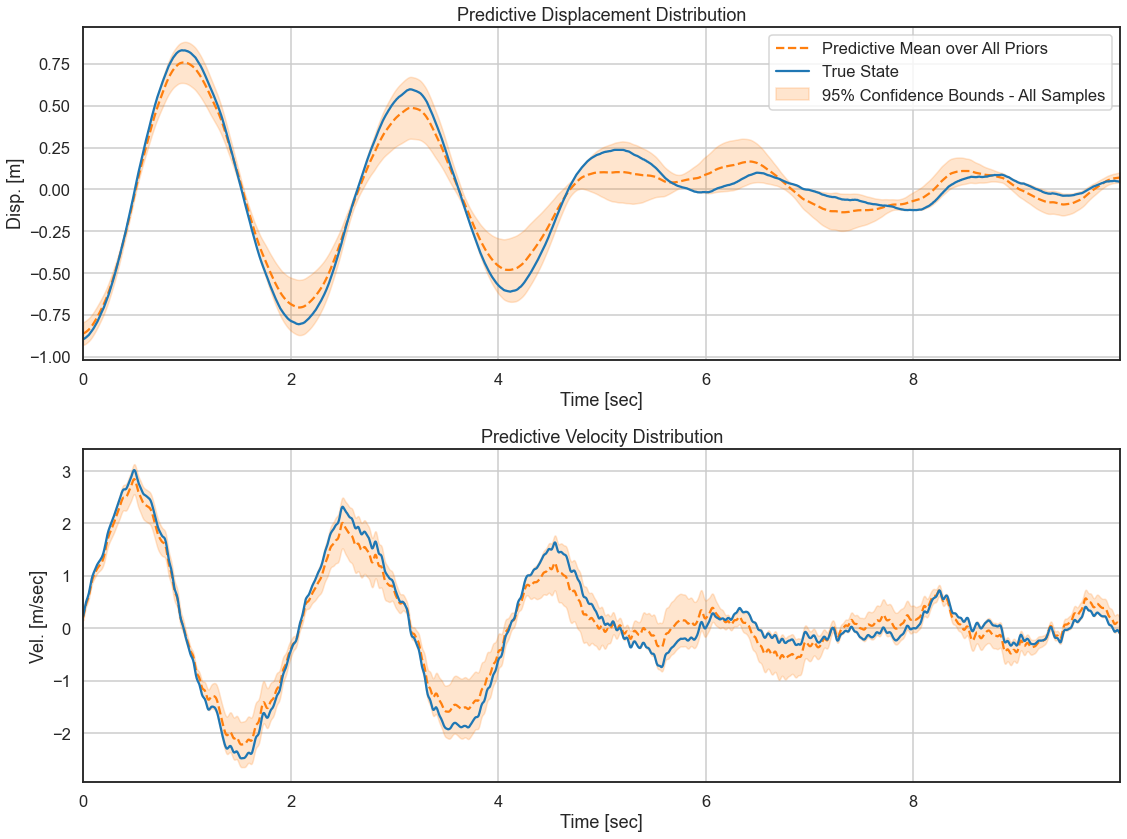

In [8]:
## Define Confidence Interval on the Predictive Estimate ##
## Given All Samples from All Candidate Models ##
lowerAll = meanAll - 2*stdAll
upperAll = meanAll + 2*stdAll

figure, ax=plt.subplots(2,1,figsize=(16,12)) 
# Plot Outer Bound -- Confidence Interval on All Samples #
ax[0].fill_between(time, lowerAll[0,:], upperAll[0,:], alpha = 0.2, 
                   color = 'C1', label='95% Confidence Bounds - All Samples')
ax[0].plot(time, meanAll[0,:], '--', color='C1', label='Predictive Mean over All Priors')
# Plot True Result #
ax[0].plot(time, predStatesTrue[0], '-', color='C0', label='True State')
ax[0].set_xlabel('Time [sec]')
ax[0].set_ylabel('Disp. [m]')
ax[0].set_title('Predictive Displacement Distribution')
ax[0].set_xlim((0, time[-1]))
ax[0].grid(1)
ax[0].legend()

# Plot Outer Bound -- Confidence Interval on All Samples #
ax[1].fill_between(time, lowerAll[1,:], upperAll[1,:], alpha = 0.2, 
                   color = 'C1', label='95% Confidence Bounds - All Samples')
ax[1].plot(time, meanAll[1,:], '--', color='C1', label='Predictive Mean over All Priors')
# Plot True Result #
ax[1].plot(time, predStatesTrue[1], '-', color='C0', label='True State')
ax[1].set_xlabel('Time [sec]')
ax[1].set_ylabel('Vel. [m/sec]')
ax[1].set_title('Predictive Velocity Distribution')
ax[1].set_xlim((0, time[-1]))
ax[1].grid(1)

plt.tight_layout()

### Plot Results for One Case
This set of figures shows the predictive uncertainty developed from a single model inferred in the previous step. 

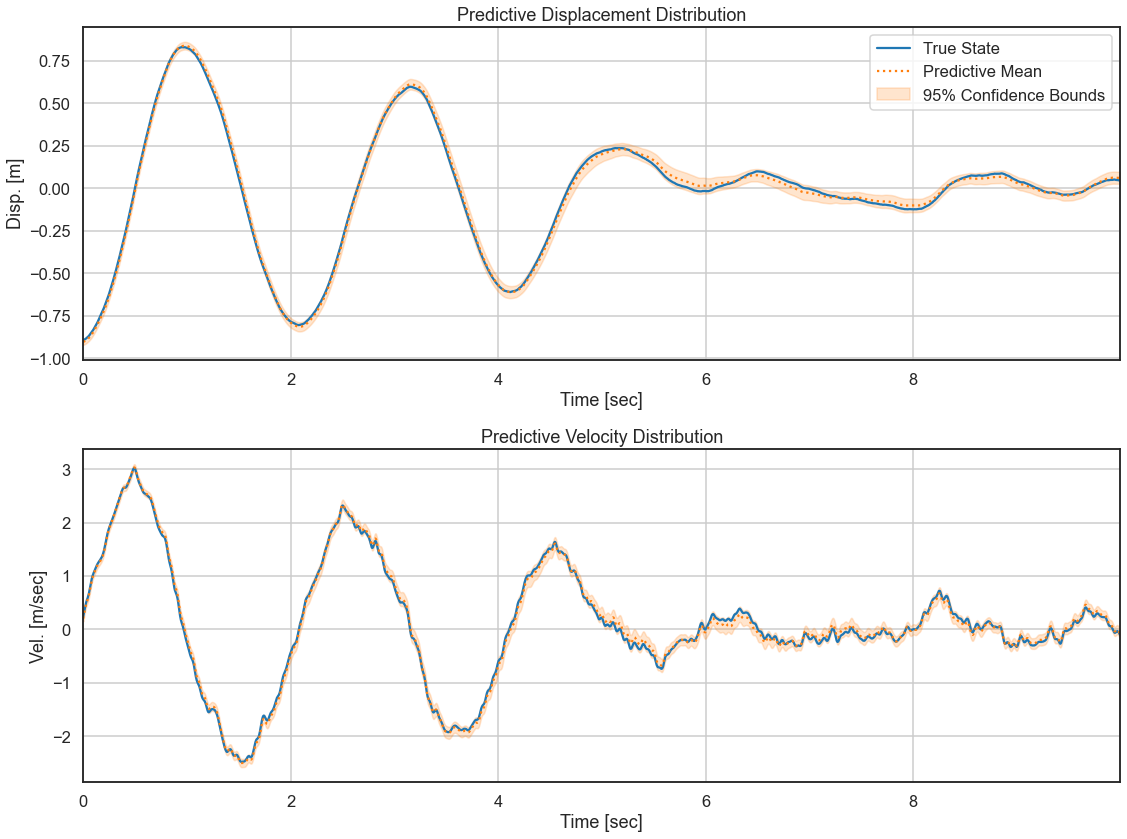

In [10]:
## Define "Best Case" in Terms of RMS Error on ##
## the Remodeled States of the Inferred Candidate Models ##
# This give us an easy choice for which model to look at
RMSDisp = np.sqrt(np.mean(np.square(states[0] - modStates[:,0,:]), axis=1))
findNans = np.isnan(RMSDisp)
RMSDisp[findNans] = 5
RMSVel = np.sqrt(np.mean(np.square(states[1] - modStates[:,1,:]), axis=1))
findNans = np.isnan(RMSVel)
RMSVel[findNans] = 5

index = np.argmin(RMSDisp)

## Select Which Candidate Model to Observe ##
caseSelect = index 

## Define Confidence Interval on the Predictive Estimate ##
## Given All Samples from the selected Candidate Model ##
lower = meanPred[caseSelect,:,:] - 2*stdPred[caseSelect,:,:]
upper = meanPred[caseSelect,:,:] + 2*stdPred[caseSelect,:,:]

## Plot Predictive States for Single Case ##
figure, ax=plt.subplots(2,1,figsize=(16,12)) 
ax[0].plot(time, predStatesTrue[0], '-', label='True State')
ax[0].plot(time, meanPred[caseSelect,0,:], ':', label='Predictive Mean')
ax[0].fill_between(time, lower[0,:], upper[0,:], alpha = 0.2, color = 'C1', label='95% Confidence Bounds')
ax[0].set_xlabel('Time [sec]')
ax[0].set_ylabel('Disp. [m]')
ax[0].set_title('Predictive Displacement Distribution')
ax[0].set_xlim((0, time[-1]))
ax[0].grid(1)
ax[0].legend()

ax[1].plot(time, predStatesTrue[1], '-', label='True State')
ax[1].plot(time, meanPred[caseSelect,1,:], ':', label='Predictive Mean')
ax[1].fill_between(time, lower[1,:], upper[1,:], alpha = 0.2, color = 'C1', label='95% Confidence Bounds')
ax[1].set_xlabel('Time [sec]')
ax[1].set_ylabel('Vel. [m/sec]')
ax[1].set_title('Predictive Velocity Distribution')
ax[1].set_xlim((0, time[-1]))
ax[1].grid(1)

plt.tight_layout()